<a href="https://colab.research.google.com/github/DGMiles/MSMUPChem/blob/main/Syed_villin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating solvated protein

- For the simulations in this notebook, we will make use of the crystal structure of the Villin Headpiece subdomain [1YRF](https://www.rcsb.org/structure/1YRF). This is relatively small protein (35 residues) consisting of three alpha helices. This is a prototypical fast folding protein, see [10.1016/j.jmb.2006.03.034](https://doi.org/10.1016/j.jmb.2006.03.034) and [10.1073/pnas.0502495102](https://doi.org/10.1073/pnas.0502495102), and it is therefore a popular benchmark for protein folding molecular dynamics simulations, e.g. [10.1073/pnas.1800690115](https://doi.org/10.1073/pnas.1800690115) (force field accuracy) and [10.1109/SC.2014.9](https://doi.org/10.1109/SC.2014.9) (computational performance)

- Before running any of the cells below make sure you select GPU from the Runtime! We will need GPU to run simulations faster.

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.1.0-1/Mambaforge-23.1.0-1-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:11
🔁 Restarting kernel...


The chunk below took approx. 3 minutes

In [ ]:
%%capture
!conda install -c conda-forge openmm mdtraj parmed
!pip install py3dmol

In [ ]:
import shutil
from sys import stdout
import matplotlib.pyplot as plt
import mdtraj
import numpy as np
import pandas

from openmm import *
from openmm.app import *
from openmm.unit import *

### Download structure

- First you need to obtain the structure file of 1YRF from PDB database.
- We will use parmed to download the PDB and select the 35 residues of protein chain omitting any other extra molecules that typically come with PDB file.

In [ ]:
import parmed

pdb = parmed.download_PDB('1YRF')

pdb = pdb[':1-35']

pdb.write_pdb('1yrf.pdb')

### Prepare solvated system

In [ ]:
# Load in the structure and add water molecules folloing a particular forcefield
pdb = PDBFile("1yrf.pdb")
modeller = Modeller(pdb.topology, pdb.positions)
forcefield = ForceField("amber14-all.xml", "amber14/tip3pfb.xml")
modeller.addHydrogens(forcefield)
modeller.addSolvent(forcefield, model="tip3p", padding=1 * nanometer)

# Forcefield together with topology is used to create openmm system containing all the forces acting on atoms.
system = forcefield.createSystem(modeller.topology, nonbondedMethod=PME, constraints=HBonds)

### Minimize and save input structure

In [ ]:
temperature = 300 * kelvin
pressure = 1 * bar

integrator = LangevinIntegrator(temperature,
                                1 / picosecond,
                                2 * femtoseconds)

system.addForce(MonteCarloBarostat(pressure,
                                   temperature))

simulation = Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)
simulation.minimizeEnergy(maxIterations=100)
positions = simulation.context.getState(getPositions=True).getPositions()

with open("init.pdb", "w") as f:
    PDBFile.writeFile(simulation.topology, positions, f)

### Run a simulation starting from a minimized structure

In [ ]:
simulation.reporters = []
simulation.reporters.append(DCDReporter("traj.dcd", 10))
simulation.reporters.append(
    StateDataReporter(stdout, 100, step=True, temperature=True, elapsedTime=True)
)
simulation.reporters.append(
    StateDataReporter(
        "scalars.csv",
        10,
        step=True,
        time=True,
        potentialEnergy=True,
        totalEnergy=True,
        temperature=True,
    )
)
simulation.step(30000)

#"Step","Temperature (K)","Elapsed Time (s)"
100,95.01399348687133,0.00020575523376464844
200,142.35100075684676,0.4943661689758301
300,169.8228463002203,0.9734013080596924
400,197.77089896960504,1.46122407913208
500,216.96430077575883,1.9995341300964355
600,233.24177149104952,2.4595282077789307
700,245.16457208812815,2.9230175018310547
800,260.2108719484462,3.3921451568603516
900,262.4988239911382,3.8450868129730225
1000,263.17054194628383,4.304726600646973
1100,275.7426273769023,4.859004497528076
1200,275.83977581286655,5.324478626251221
1300,282.08169684336974,5.796014785766602
1400,283.500907796248,6.267695426940918
1500,292.6025118314106,6.747467994689941
1600,290.55162369729396,7.2019665241241455
1700,290.4165247420562,7.684858798980713
1800,286.12039714071983,8.226345777511597
1900,288.7043425772817,8.717578649520874
2000,294.38877328950855,9.187098026275635
2100,297.38826842523275,9.902440547943115
2200,296.9938209791039,10.748982429504395
2300,298.1770270555842,11.574804306030

> Make an estimate of the computational cost (wall time) on your current hardware to run a sufficiently long simulation to observe spontaneously a protein folding event for this fast folder. The required simulation time is approximately $4 \mathrm{\mu s}$. Would such a calculations be feasible?

### Analyzing simulation

<Axes: xlabel='Time (ps)'>

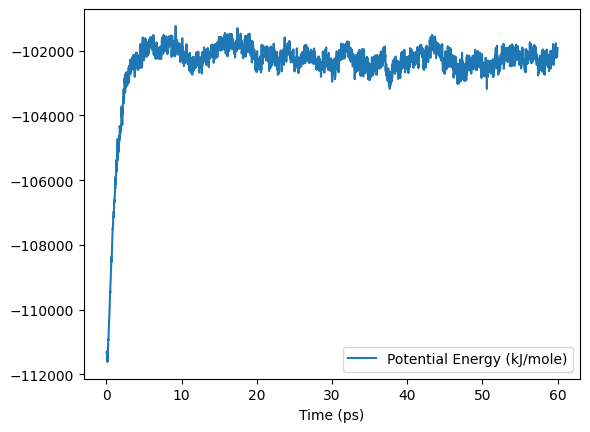

In [ ]:
df = pandas.read_csv("scalars.csv")
df.plot(kind="line", x="Time (ps)", y="Potential Energy (kJ/mole)")

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!pip install nglview


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 60.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.9/214.9 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.0/807.0 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.2/385.2 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
import mdtraj
import nglview

traj = mdtraj.load("traj.dcd", top="init.pdb")
view = nglview.show_mdtraj(traj)
view

NGLWidget(max_frame=2999)

In [ ]:
!zip villin.zip *